# Multivariate ITS model for unsaturated markets

This notebook showcases how to use the Multivariate Interrupted Time Series (MVITS) model to estimate where new product sales came from in the case of an unsaturated market. That is, when a new product can lead to (some) reductions in sales of existing products, but some of the new product sales are in the form of growing the market.

We will also see a scenario like this which the MVITS model is (at least currently) not able to handle. It is important to be aware of the limitations of the model and whether your dataset fits the assumptions of the model.

## Notebook setup

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from pymc_marketing.customer_choice import (
    MVITS,
    generate_unsaturated_data,
    plot_product,
)

rng = np.random.default_rng(123)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams.update({"figure.constrained_layout.use": True})


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## An unsaturated market example

Let's explore a situation where a new product is released, and it sells reasonably well. _Some_ of those new product sales are coming from existing products, but _some_ are coming from new customers.

So the total sales increase, but importantly, those additional sales are directed to the new product. This is likely a pretty common scenario in the real world. A new product is released and perhaps it is far better than existing products. So if it sells 1000 units, then some of those sales will be 'taken' from sales of existing products, but the new product is so good that it attracts new customers that would not have purchased any of the existing products. This could happen if the new product falls below a psychologically significant price point, or is associated with new marketing, or simply has a new feature that attracts new customers.

In [2]:
scenario1 = {
    "total_sales_before": [800],
    "total_sales_after": [950],
    "total_sales_sigma": 10,
    "treatment_time": 40,
    "n_observations": 100,
    "market_shares_before": [[500 / 800, 300 / 800, 0]],
    "market_shares_after": [[400 / 950, 200 / 950, 350 / 950]],
    "market_share_labels": ["competitor", "own", "new"],
    "random_seed": rng,
}

data = generate_unsaturated_data(**scenario1)

data.head()

product,competitor,own,new,pre
day,,,,
0,497,293,0,True
1,471,325,0,True
2,522,290,0,True
3,497,304,0,True
4,509,300,0,True


So the key properties of this example are:
* The total sales increase when the new product is released.
* Some of the new product sales come from existing products. We can tell this because a) the existing products' sales decrease, and b) the new product's sales are greater than the decrease in existing products' sales.
* The absolute sales numbers for existing products decrease. This is one of the key assumptions of the MVITS model.

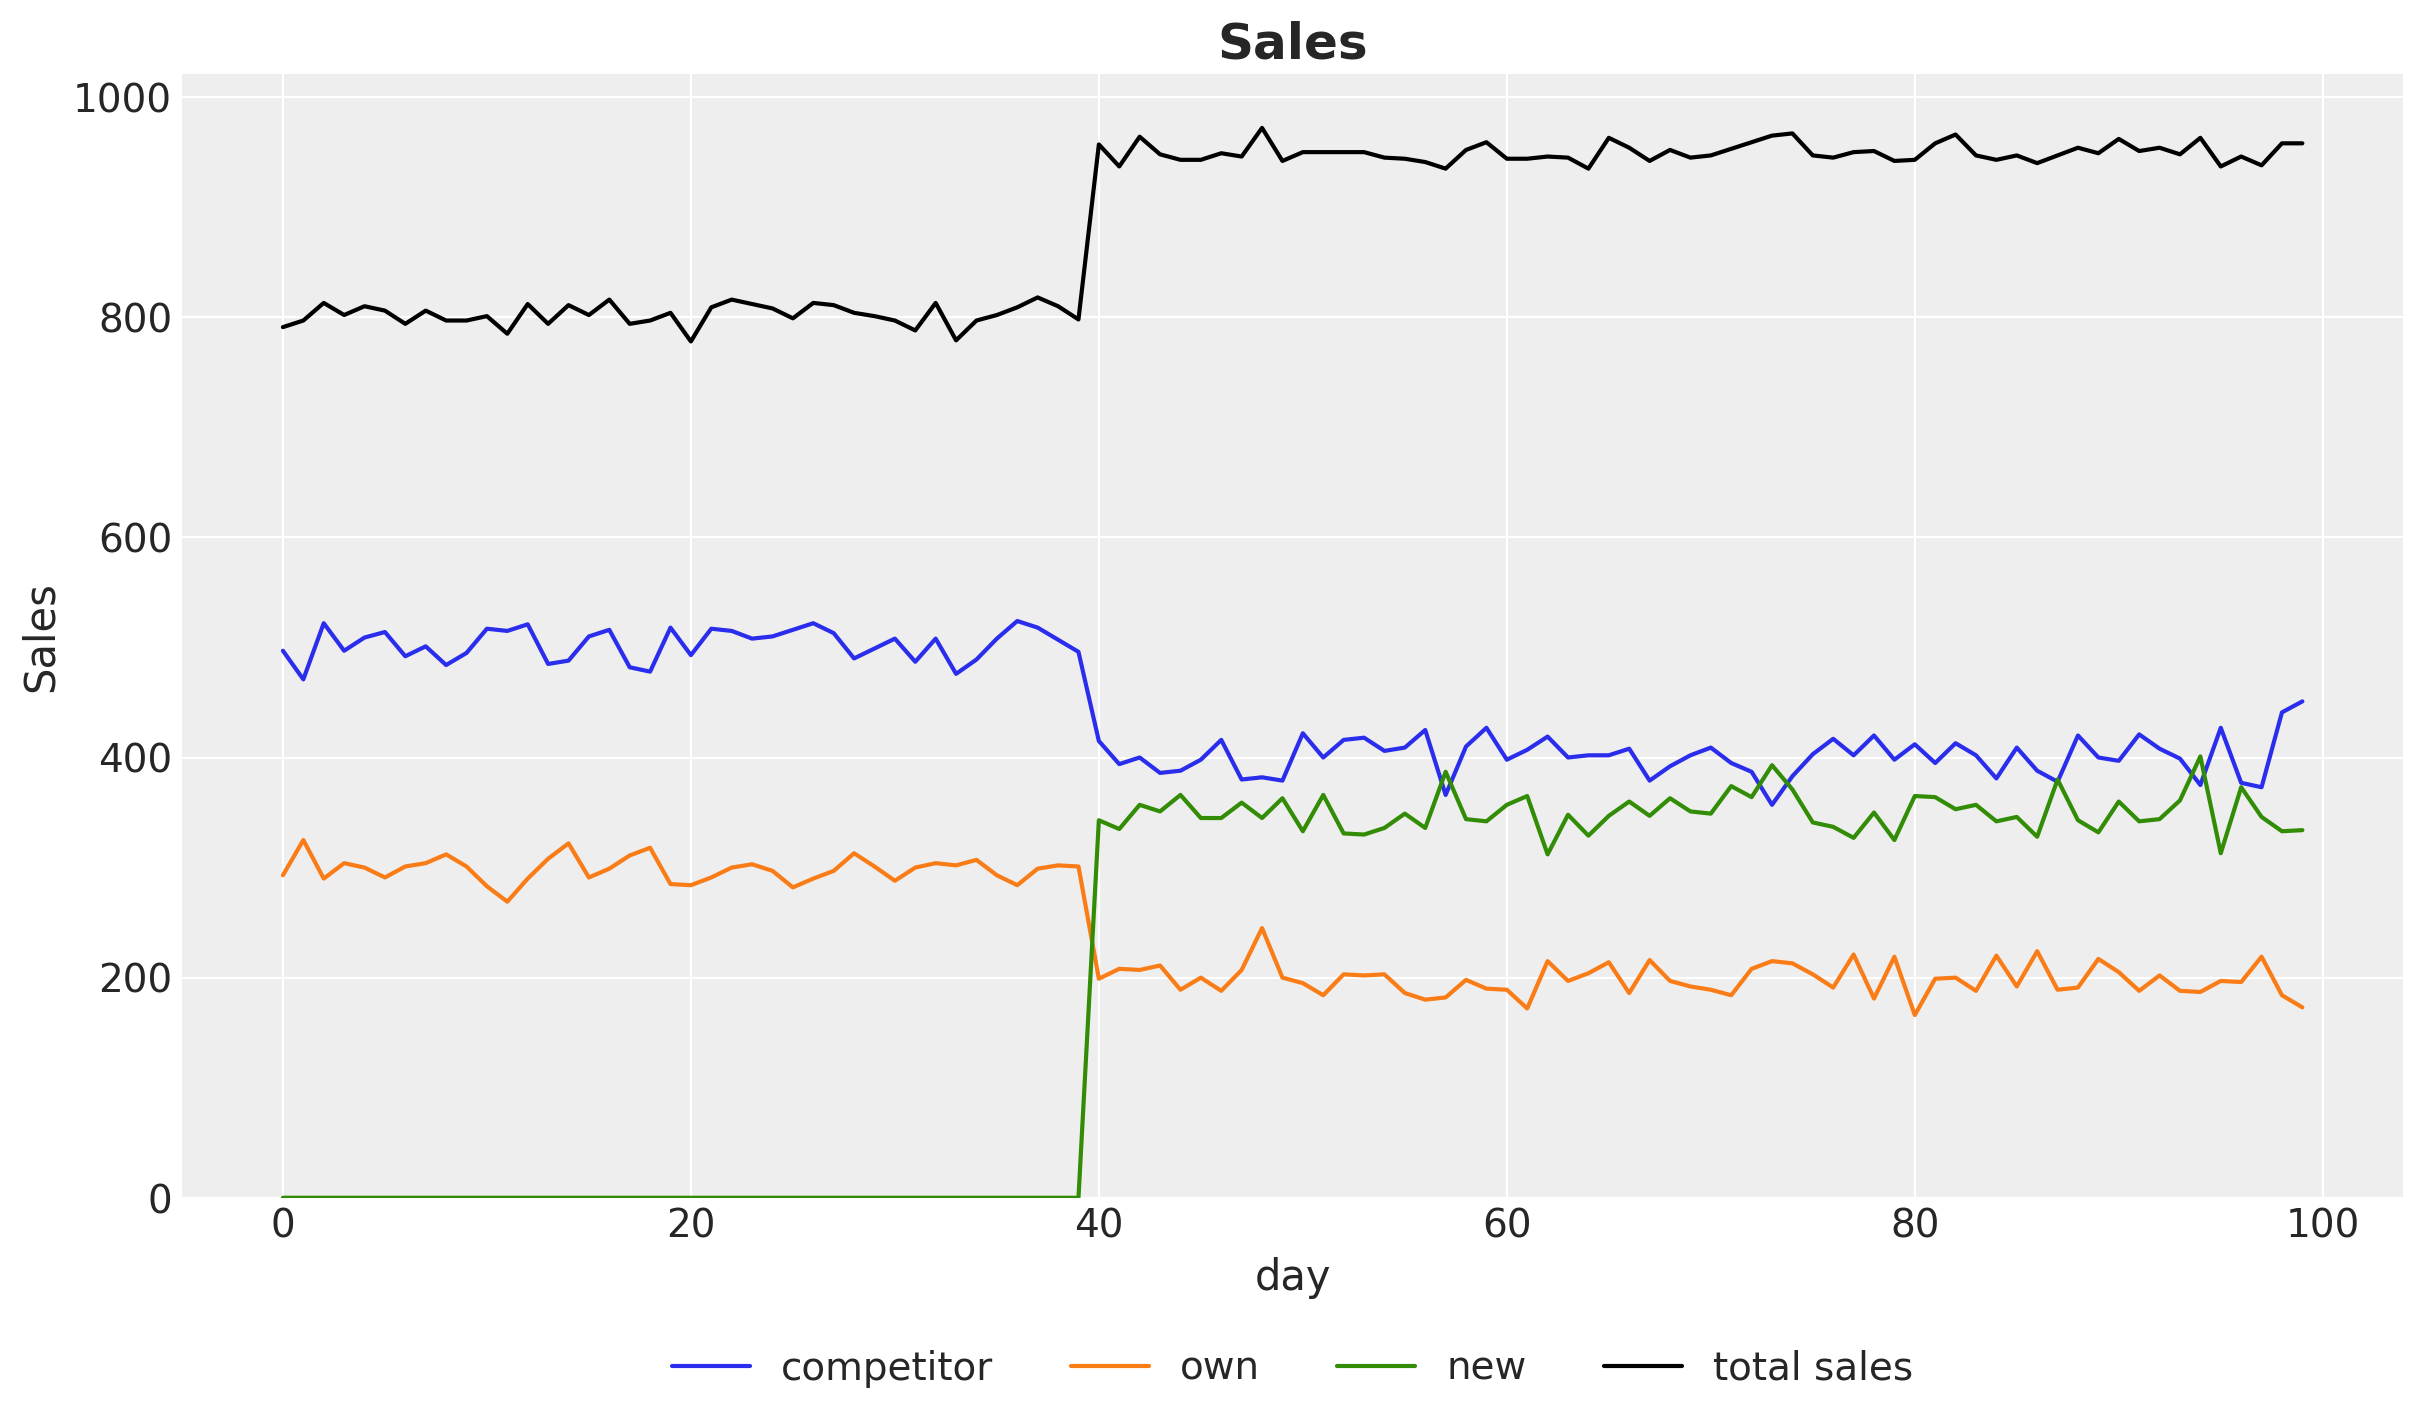

In [3]:
fig, ax = plt.subplots()
plot_product(data, ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set_title("Sales", fontsize=18, fontweight="bold");

In [4]:
model1 = MVITS(
    existing_sales=["competitor", "own"],
    saturated_market=False,
    sampler_config={"tune": 1_500, "draws": 2_000},
)

In [5]:
model1.model_config

{'intercept': Prior("Normal", dims="existing_product"),
 'likelihood': Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", dims="existing_product"), dims=("time", "existing_product")),
 'market_distribution': Prior("Dirichlet", a=[0.5 0.5 0.5], dims="all_sources")}

In [6]:
model1.inform_default_prior(
    data=data.loc[: scenario1["treatment_time"], ["competitor", "own"]]
)
model1.model_config

{'intercept': Prior("Normal", mu=[500.75609756 295.95121951], sigma=[19.83655778 19.16631318], dims="existing_product"),
 'likelihood': Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", sigma=19.501435478675347, dims="existing_product"), dims=("time", "existing_product")),
 'market_distribution': Prior("Dirichlet", a=[0.5 0.5 0.5], dims="all_sources")}

In [7]:
model1.sample(data[["competitor", "own"]], data["new"]);

Sampling: [beta_all, intercept, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_all, y_sigma]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 4 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

We can see that the model does a reasonable job of accounting for the data in that it capures the pre-introduction sales levels and the reduction in sales at the point the new product is introduced.

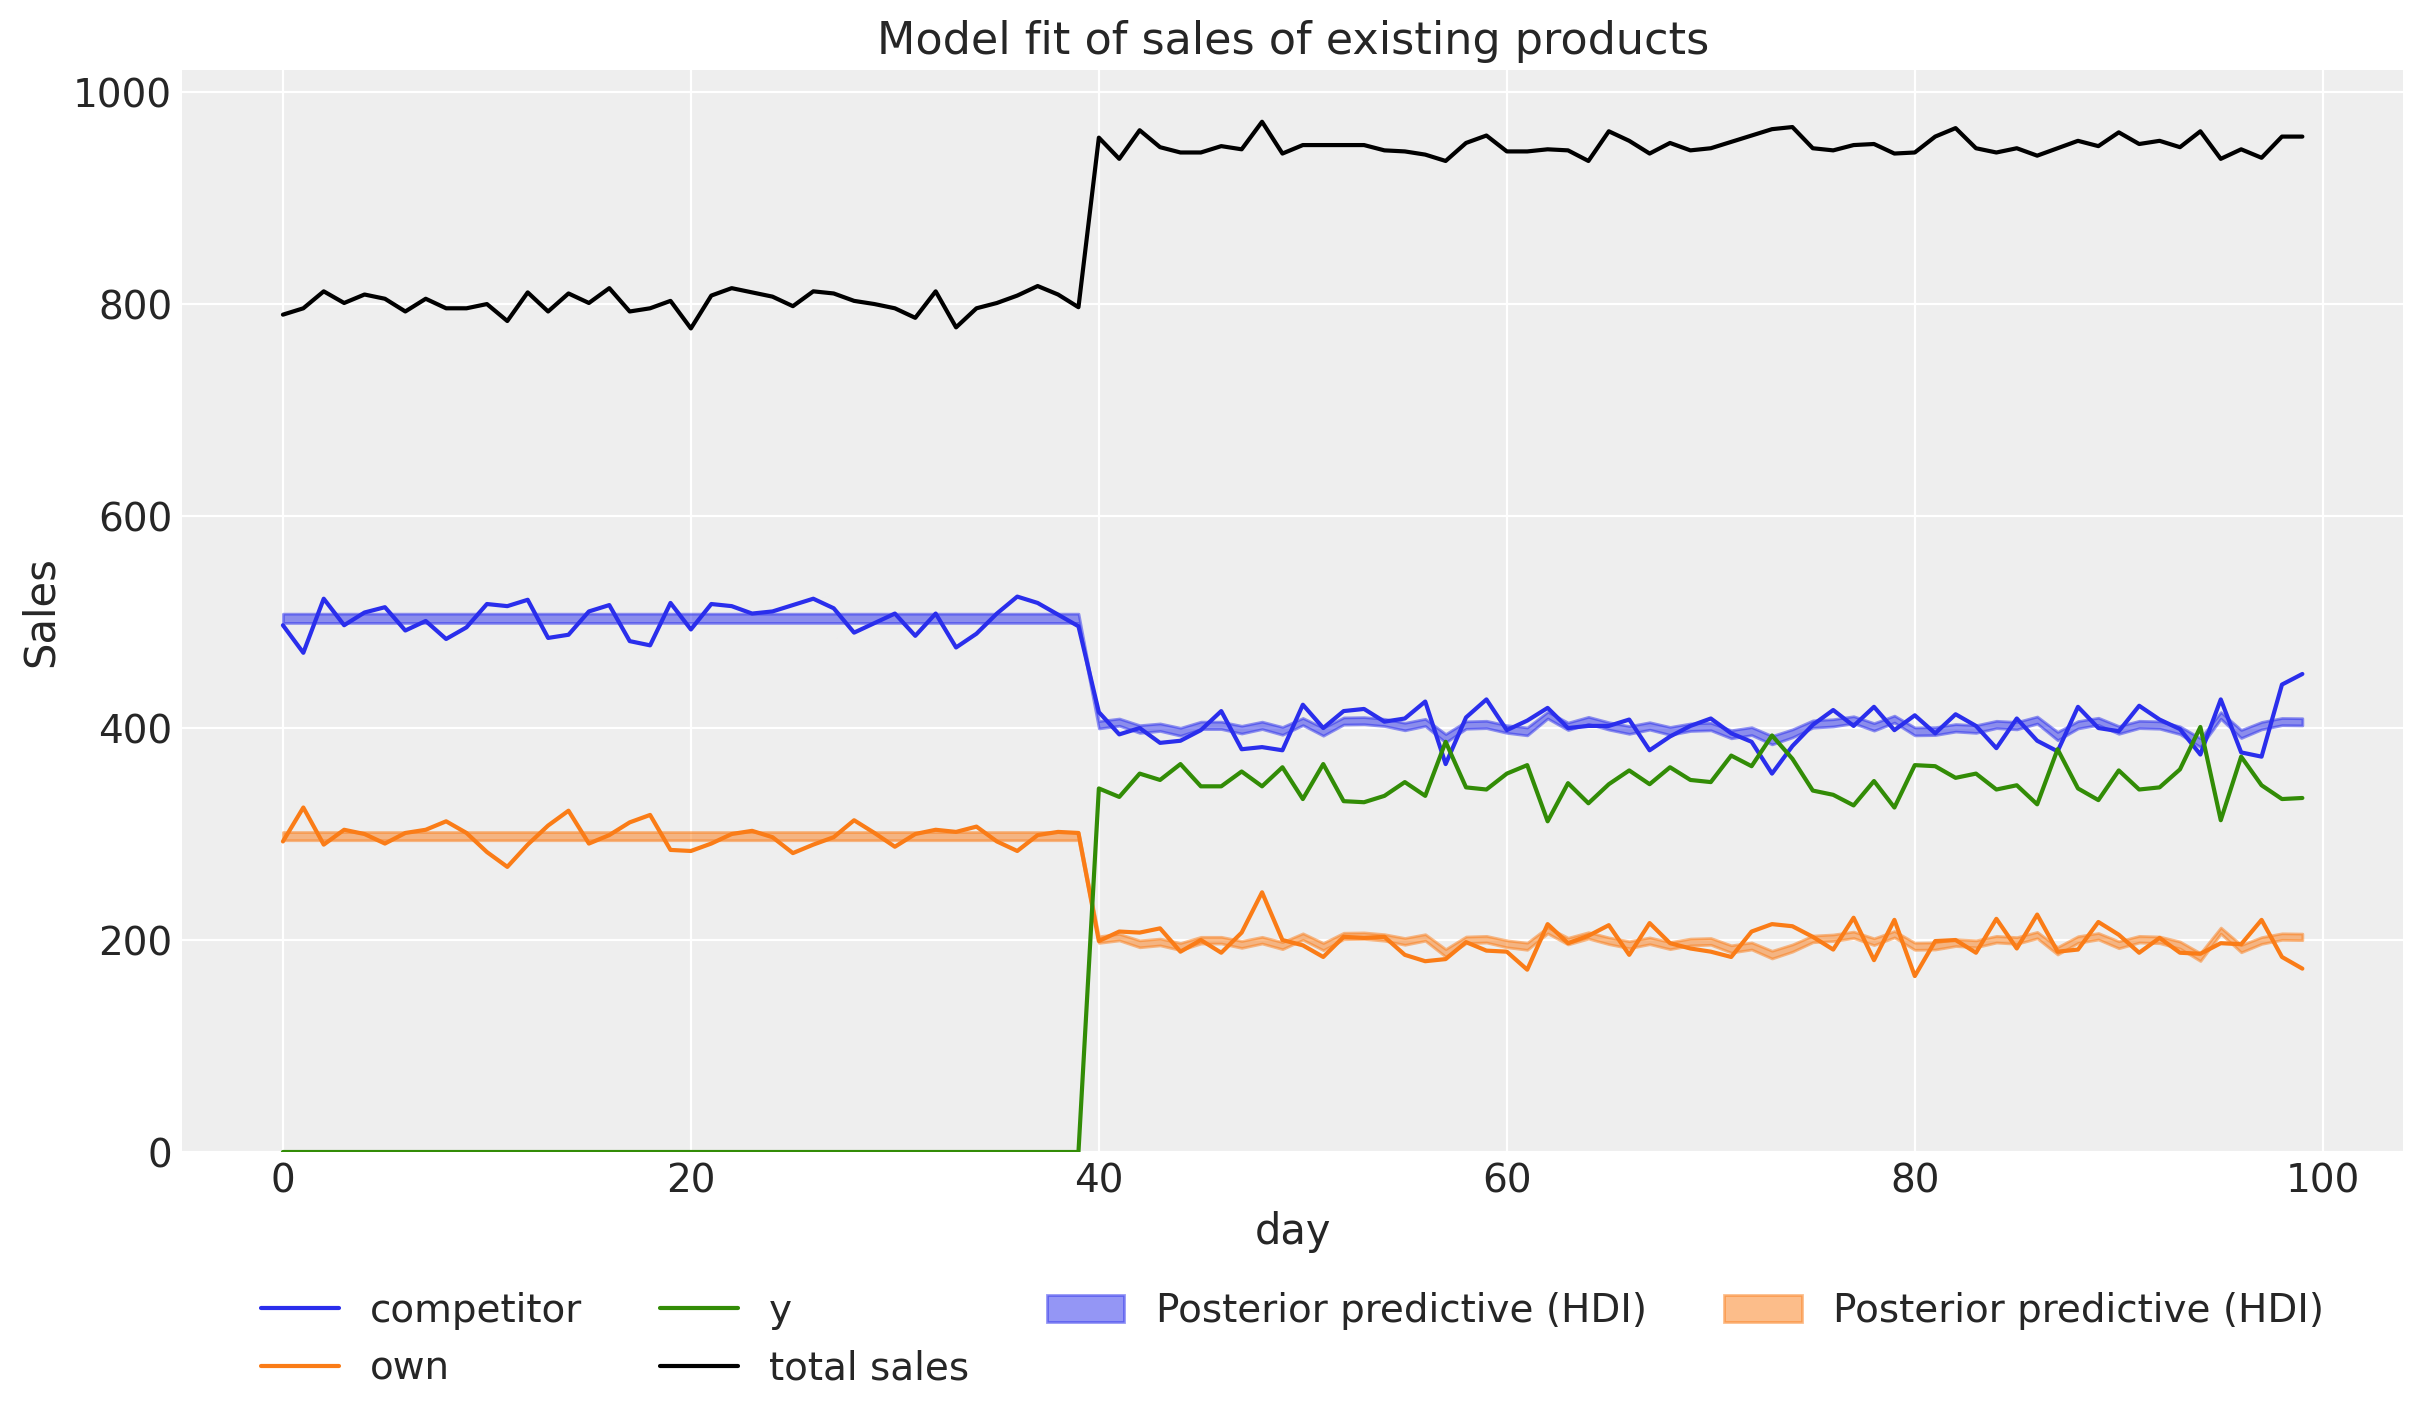

In [8]:
fig, ax = plt.subplots()
model1.plot_fit(ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4);

The counterfactual plot also looks good. The model estimates the counterfactual sales of the existing products would have continued as they were from before the new product was introduced.

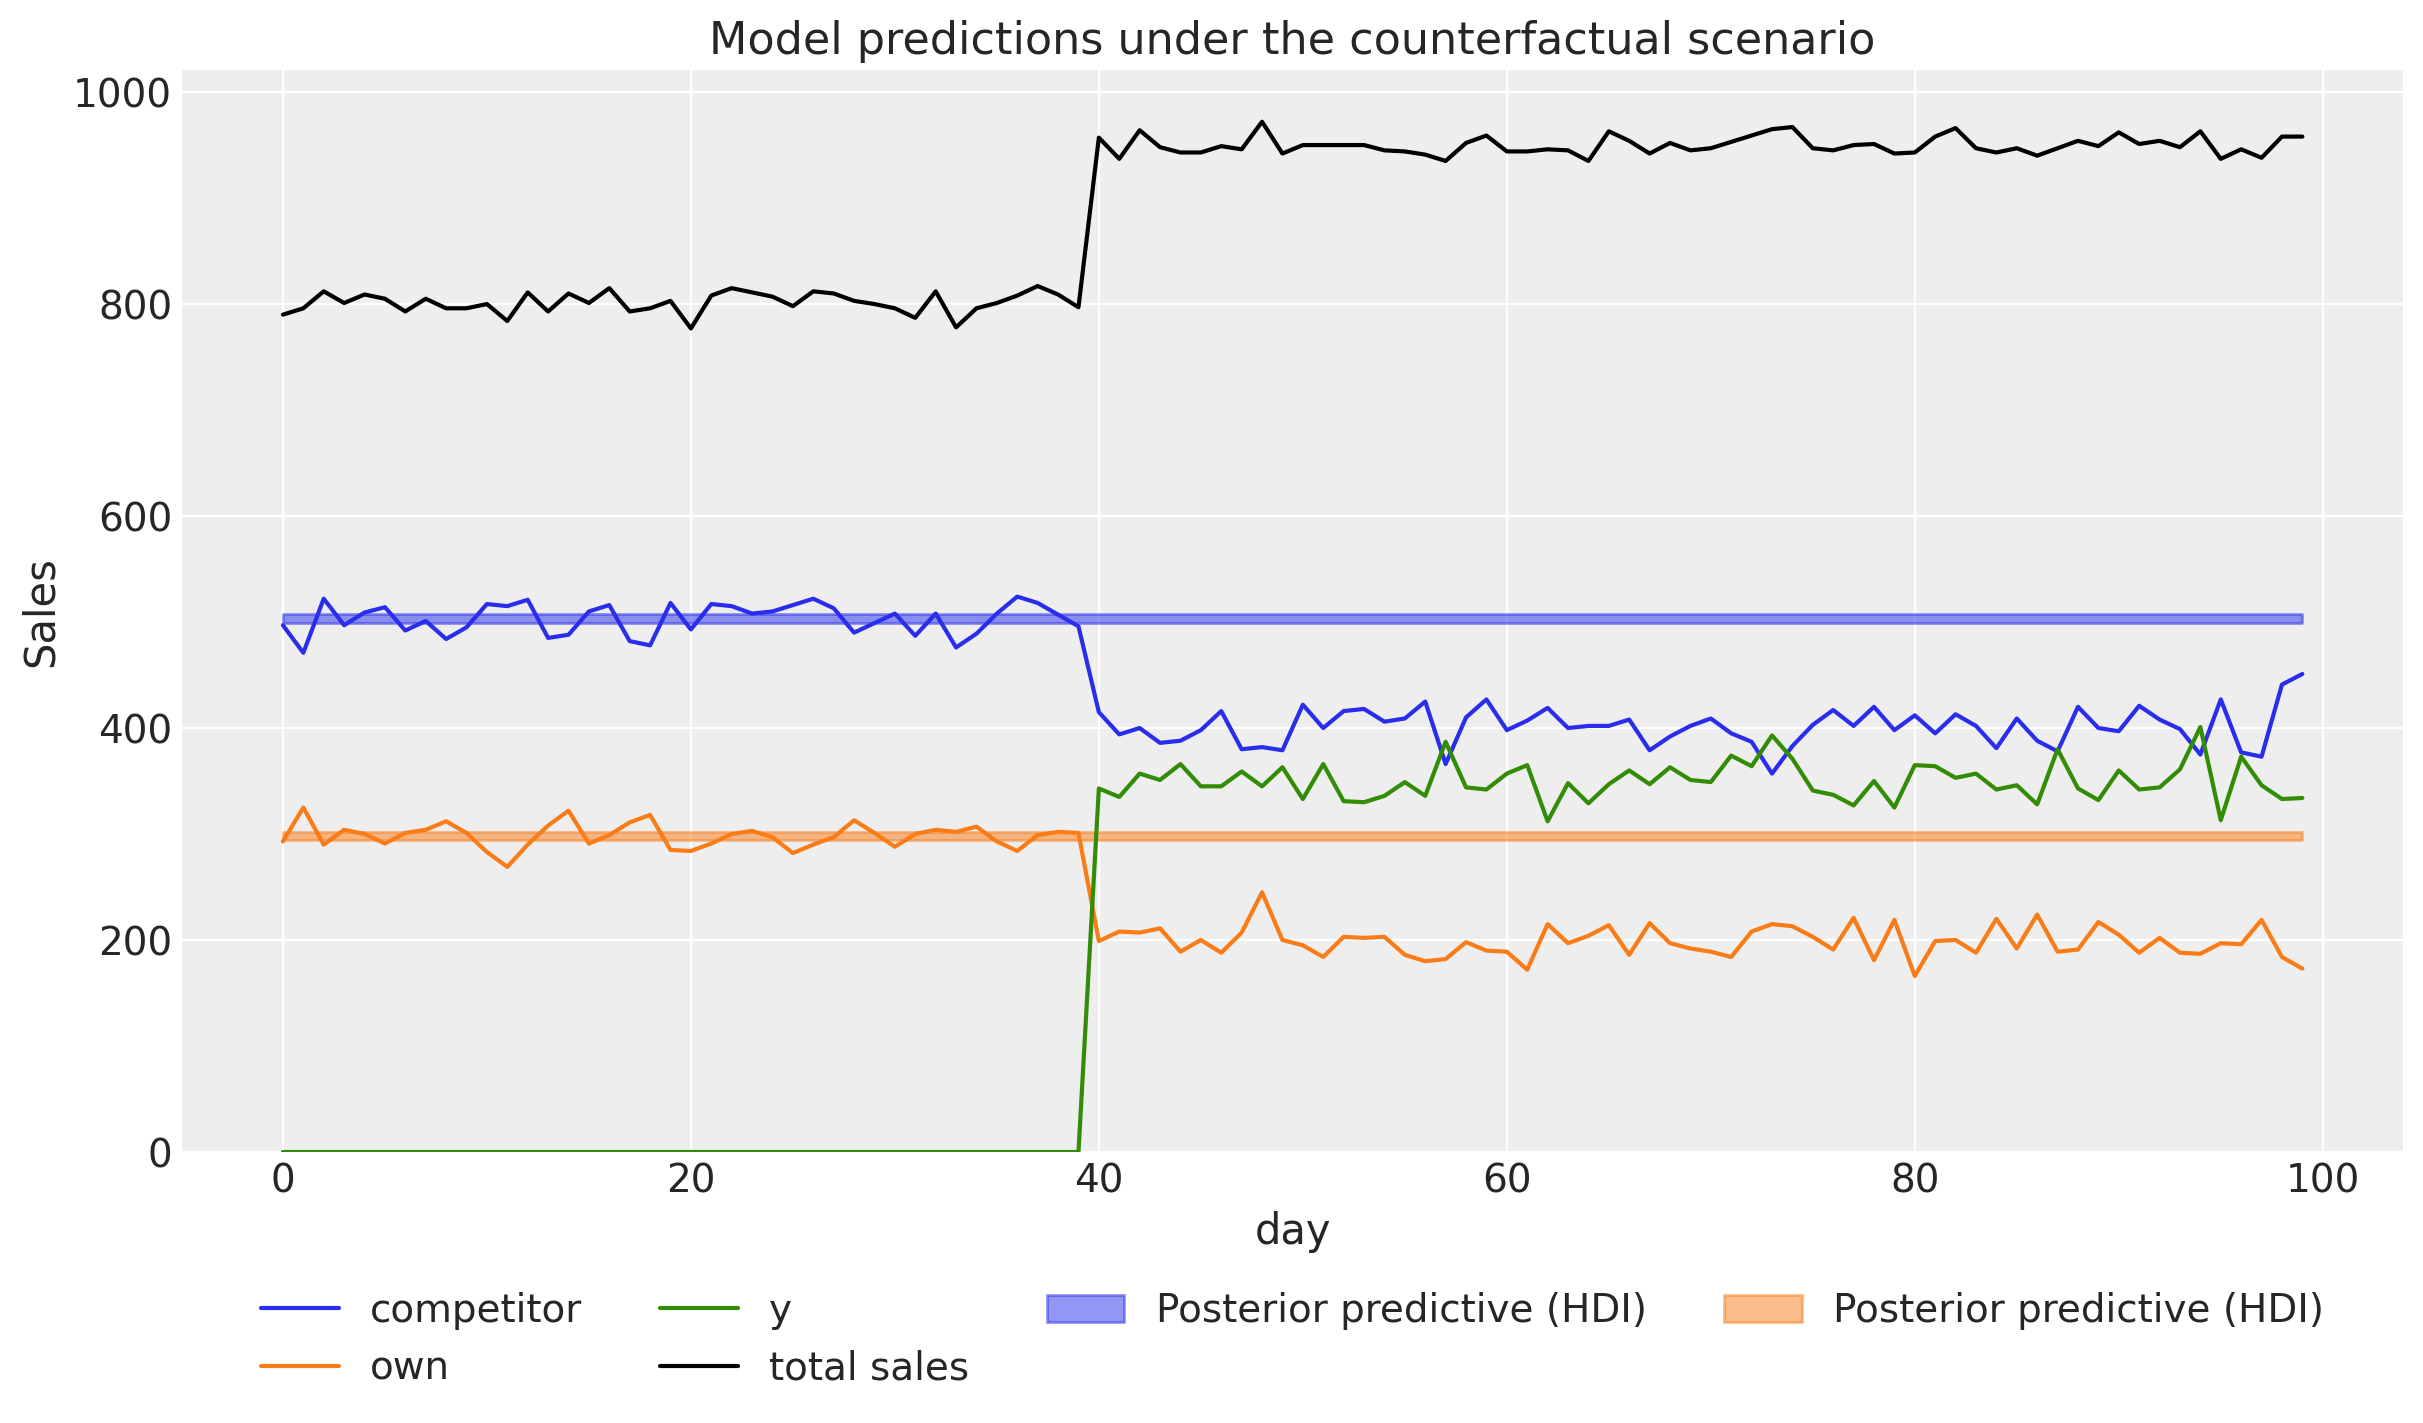

In [9]:
fig, ax = plt.subplots()
model1.plot_counterfactual(ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4);

The model shows that introduction of the new product caused a decline in the sales of existing products.

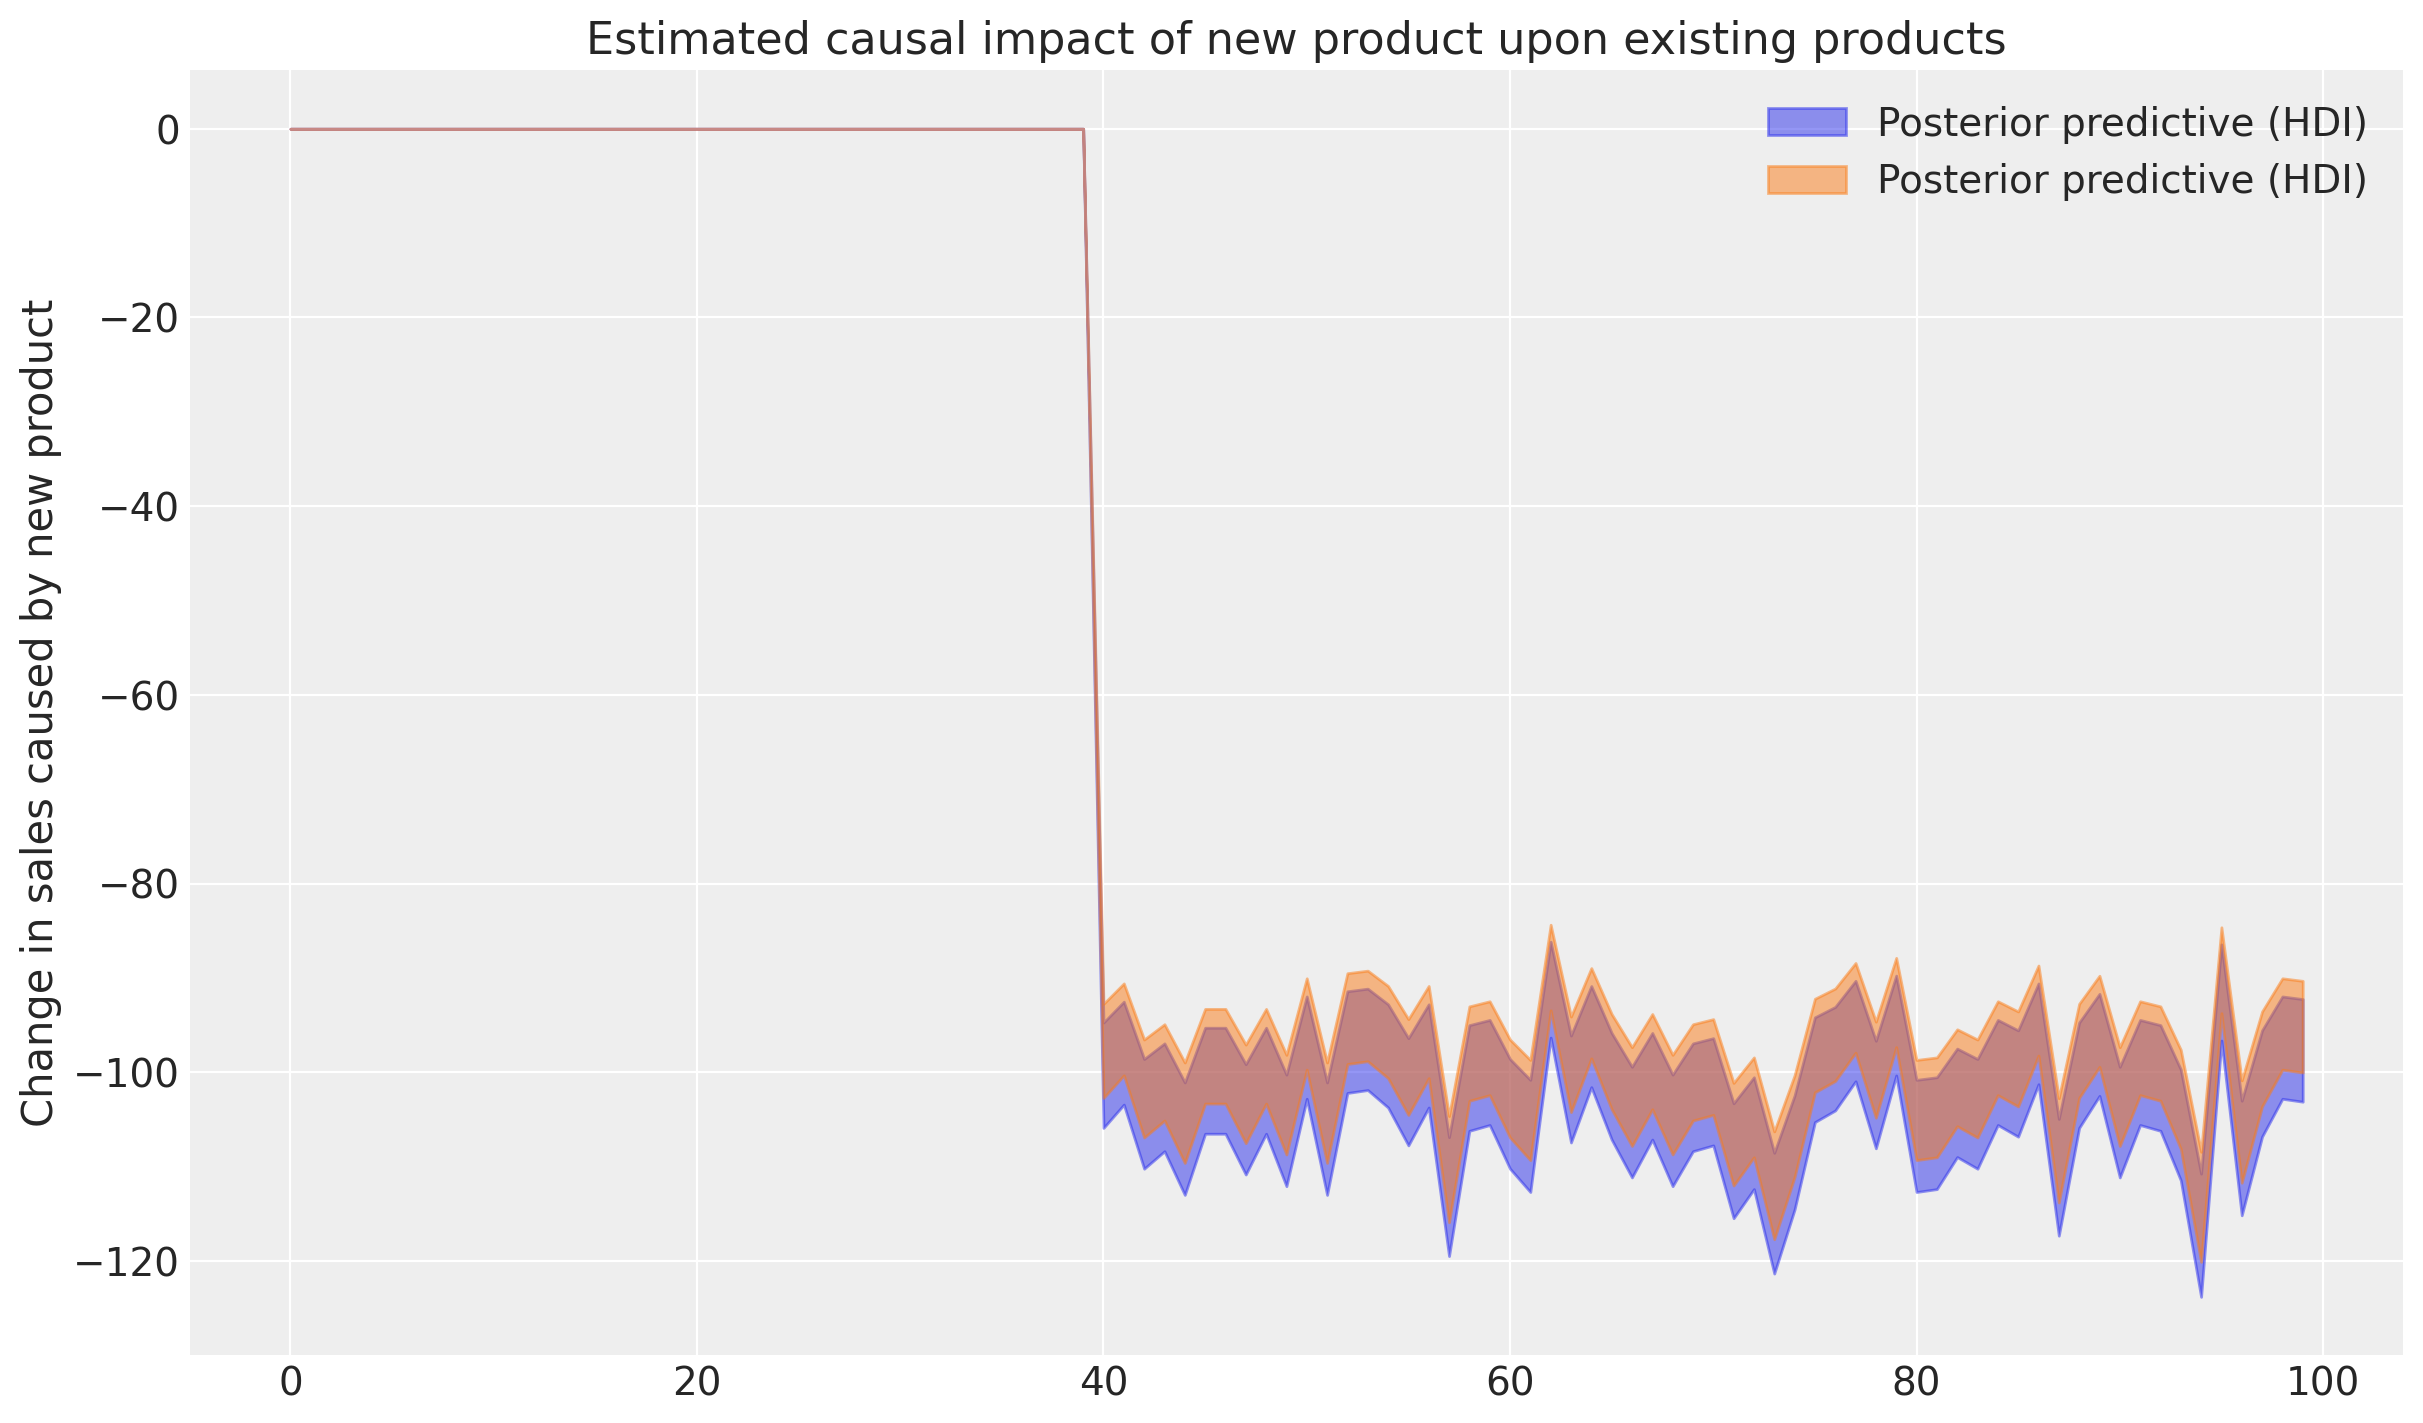

In [10]:
model1.plot_causal_impact_sales();

And looking at the $\beta$ parameters, we can see:
* `beta_all[competitor]` shows that about 33% of the new product sales are incremental, in that they are taken from competitor sales.
* `beta_all[own]` shows that about 27% of the new product sales are cannibalisations, in that they are taken from your own companies existing product sales. 
* `beta_all[new]` shows that about 40% of the new product sales are from growing the market.

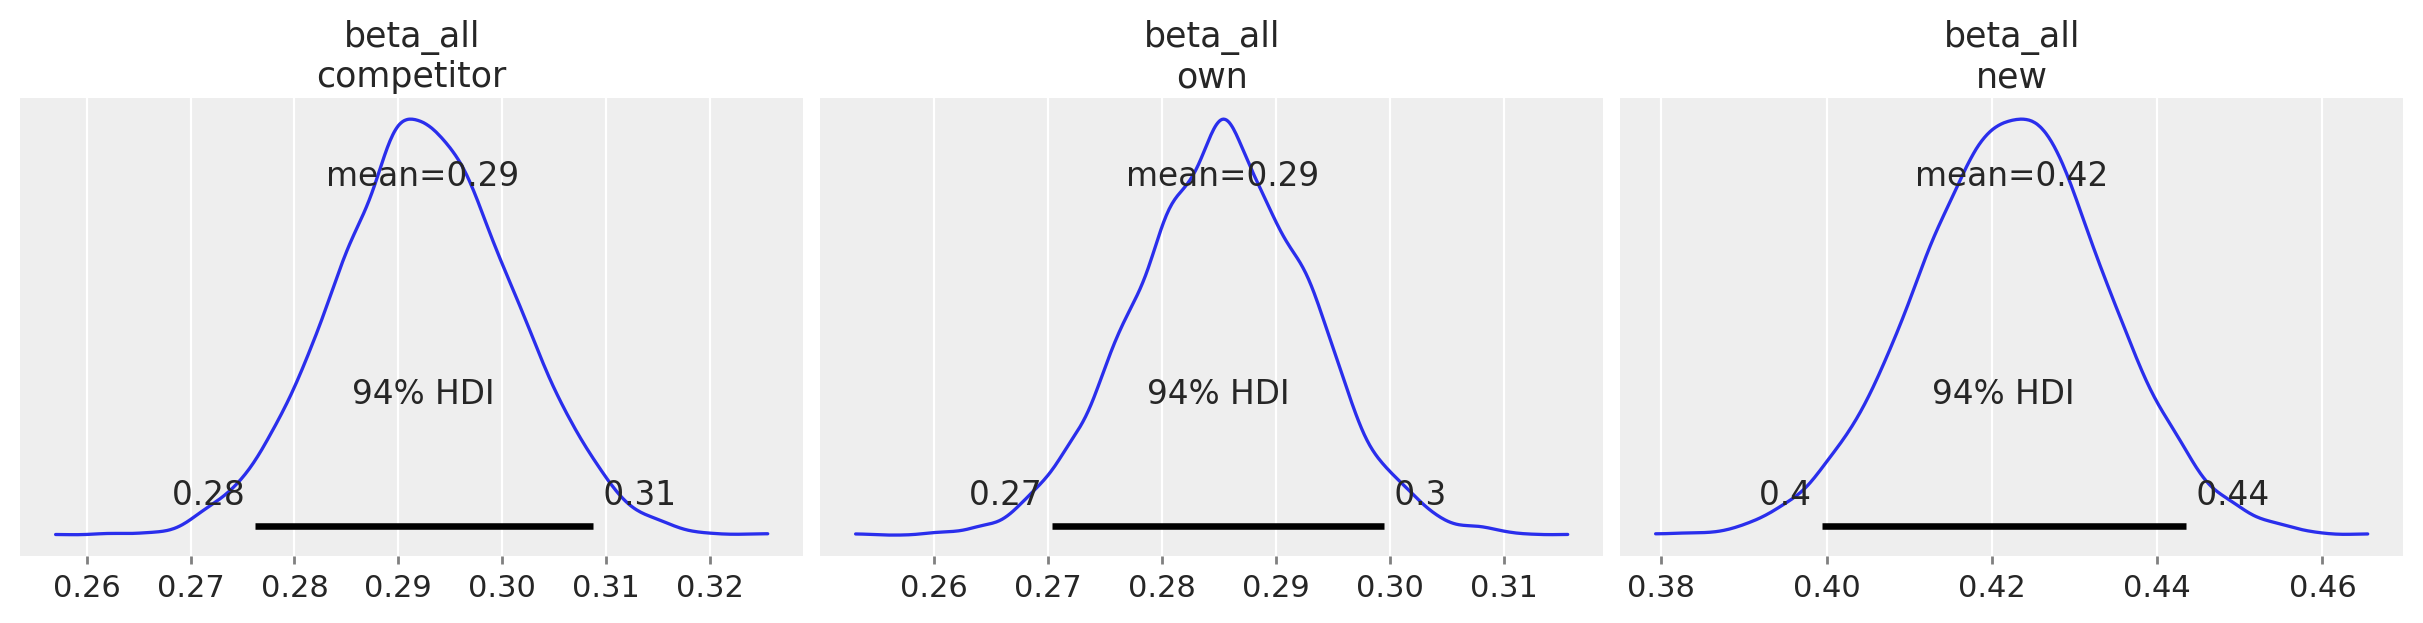

In [11]:
az.plot_posterior(model1.idata, var_names=["beta_all"], textsize=11, figsize=(12, 3));

```{admonition} Beta variables
:class: note

When we model unsaturated markets using the `saturated_market=False` kwarg in the MVITS model, we need to use the `beta_all` variable, not the `beta` variable. 

## Limits to the MVITS model

In this section we will explore a scenario which the MVITS is incapable of modeling, at least in its current form. Namely, it cannot deal with situations where the sales of existing products _increase_ after the introduction of the new product. This is because the MVITS model assumes that the sales of existing products are constant over time, and that the new product only affects the sales of the existing products negatively.

```{admonition} Warning
:class: warning

This section is meant to demonstrate a data scenario that the MVITS is _not_ capable of modeling well. At least, not in its current form.

In [12]:
scenario2 = {
    "total_sales_before": [1000],
    "total_sales_after": [1400],
    "total_sales_sigma": 20,
    "treatment_time": 40,
    "n_observations": 100,
    "market_shares_before": [[0.7, 0.3, 0]],
    "market_shares_after": [[0.65, 0.25, 0.1]],
    "market_share_labels": ["competitor", "own", "new"],
    "random_seed": rng,
}

data = generate_unsaturated_data(**scenario2)

In this scenario:
* The market share of competitor products starts at 70% and reduces to 65% when the new product is introduced.
* The market share of our own company products starts at 30% and reduces to 25% when the new product is introduced.
* The new product gains 10% market share when it is introduced.
* However, the introduction of the new product also increases the total size of the market from 1000 to 1400 units on average.
* This means that while the market shares of the existing products are reduced, their sales actually increase.

It is this increase in sales numbers that the MV-ITS model (as currently implemented) cannot handle.

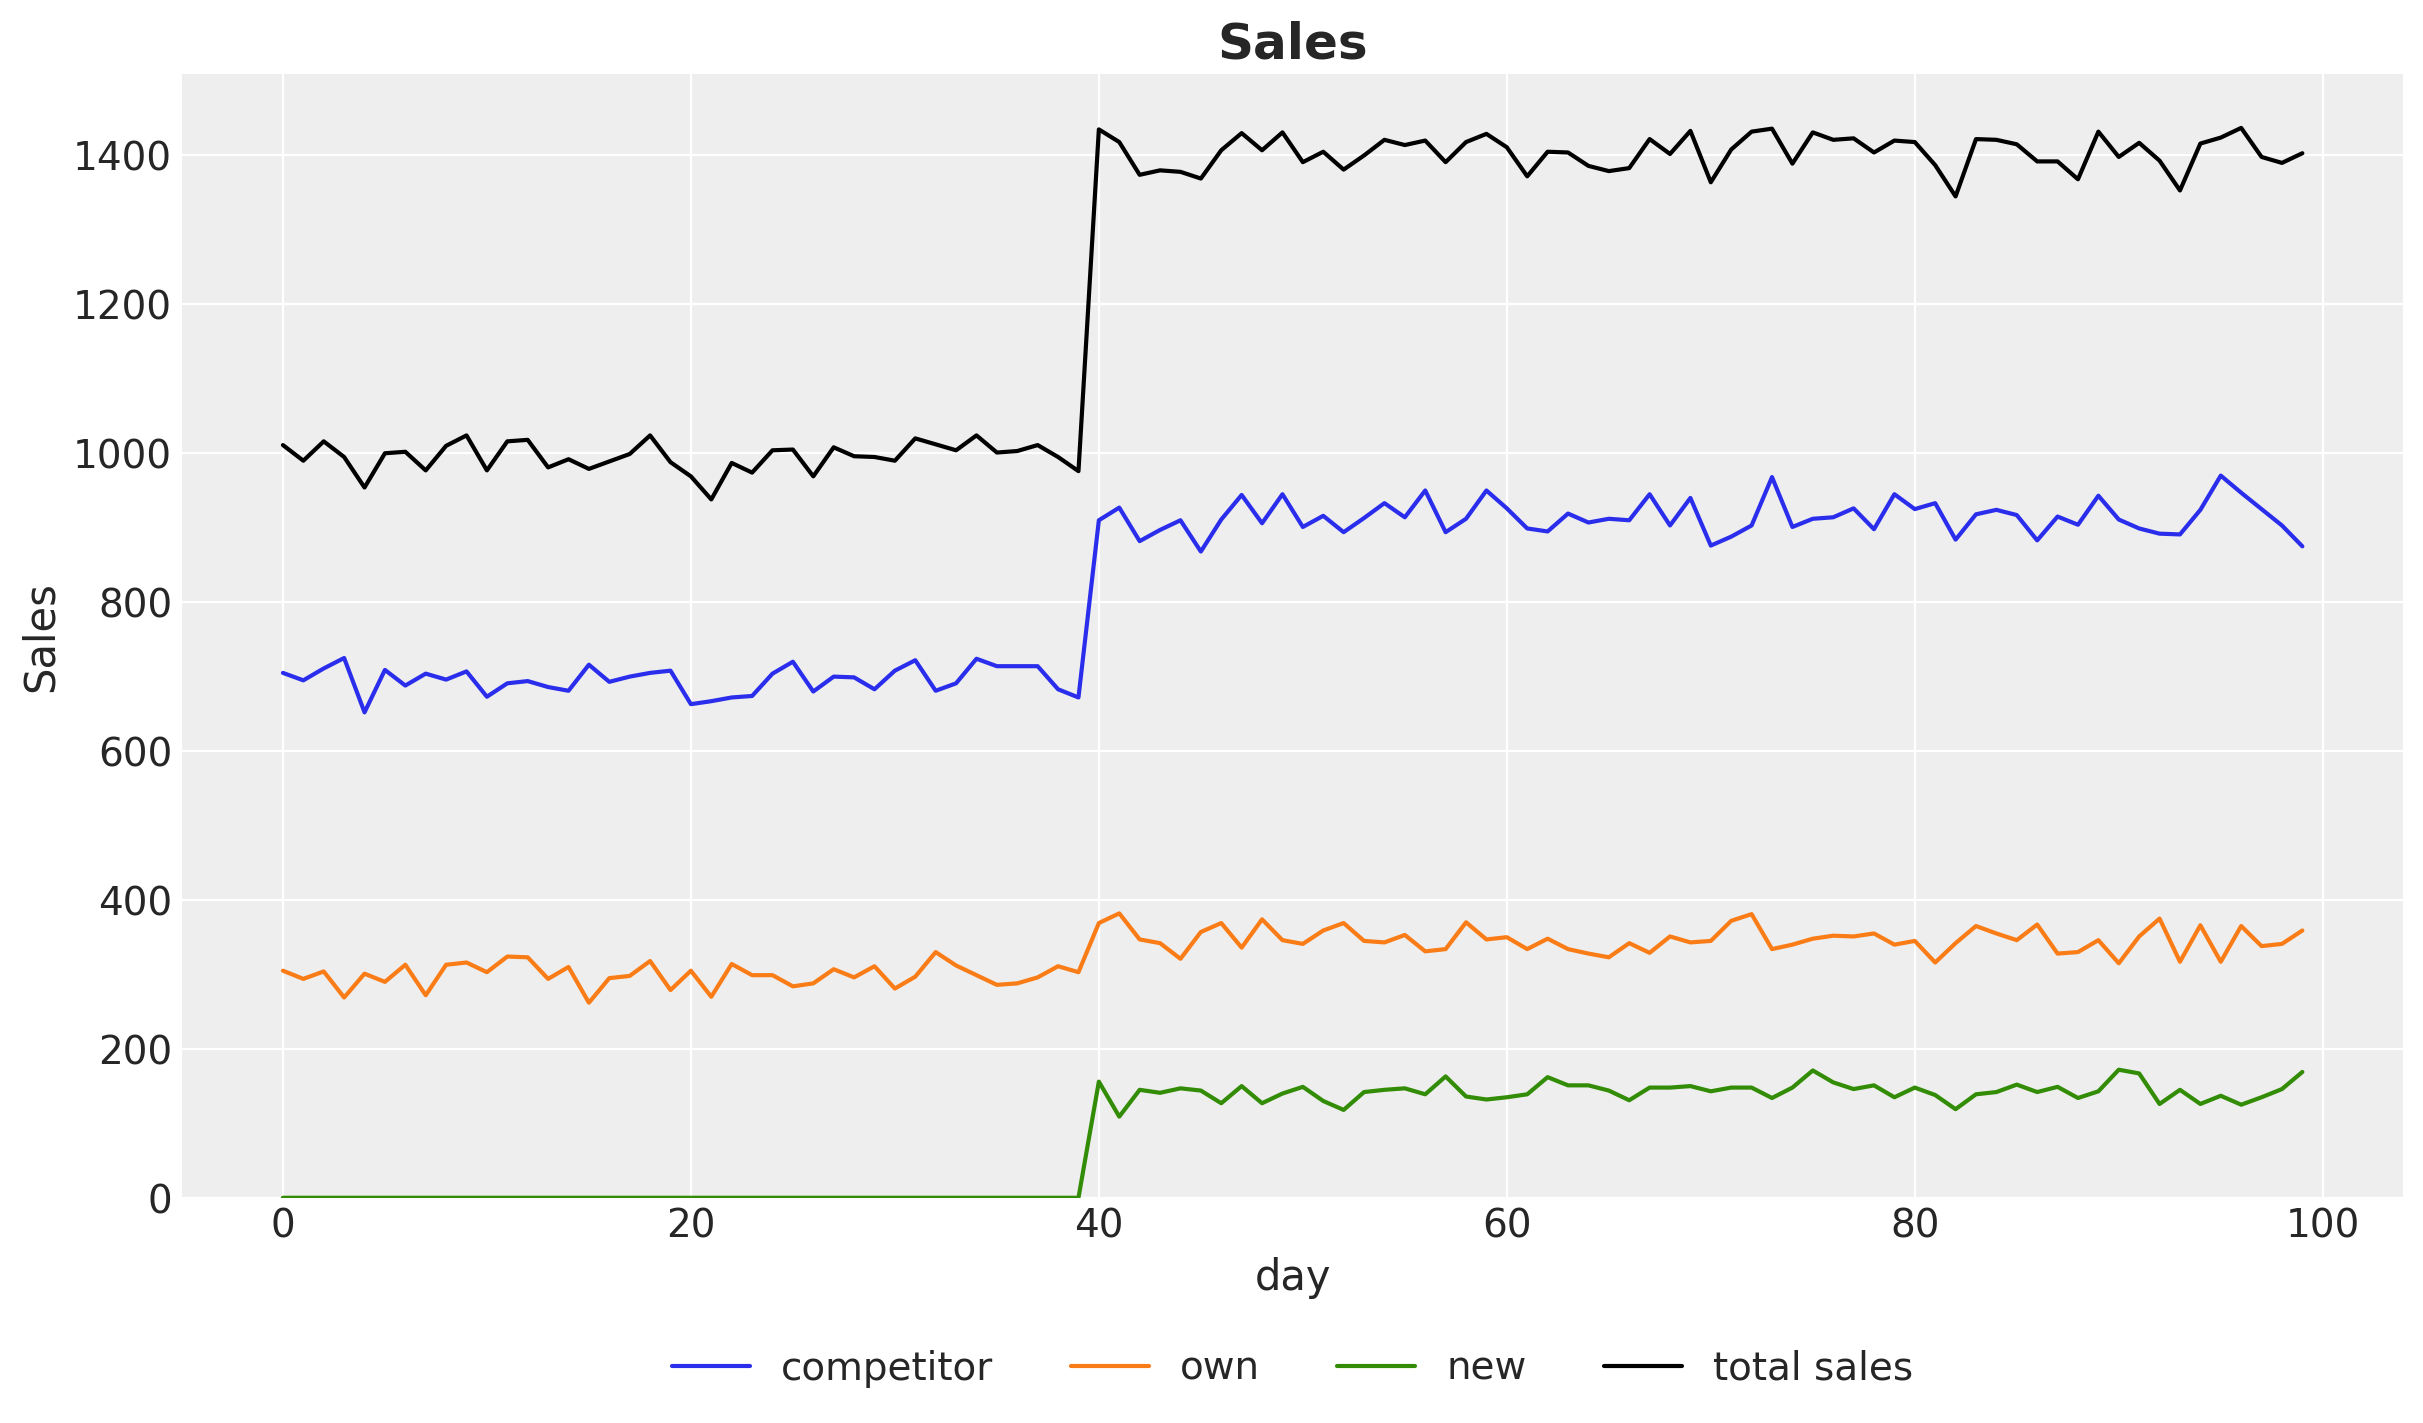

In [13]:
fig, ax = plt.subplots()
plot_product(data, ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set_title("Sales", fontsize=18, fontweight="bold");

In [14]:
model2 = MVITS(
    existing_sales=["competitor", "own"],
    saturated_market=False,
    sampler_config={"tune": 1_500, "draws": 2_000},
)

In [15]:
model2.inform_default_prior(
    data=data.loc[: scenario2["treatment_time"], ["competitor", "own"]]
)

model2.model_config

{'intercept': Prior("Normal", mu=[700.82926829 300.68292683], sigma=[37.92288388 18.94523558], dims="existing_product"),
 'likelihood': Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", sigma=28.434059731654337, dims="existing_product"), dims=("time", "existing_product")),
 'market_distribution': Prior("Dirichlet", a=[0.5 0.5 0.5], dims="all_sources")}

In [16]:
model2.sample(data[["competitor", "own"]], data["new"]);

Sampling: [beta_all, intercept, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_all, y_sigma]


Output()

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 5 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

Sampling: [y]


Output()

Let's explore how this fails.

First, we can see that the model does not do a good job of accounting for the data. The posterior predictive checks show that the model is not accurately capturing the sales data prior to the new product introduction.

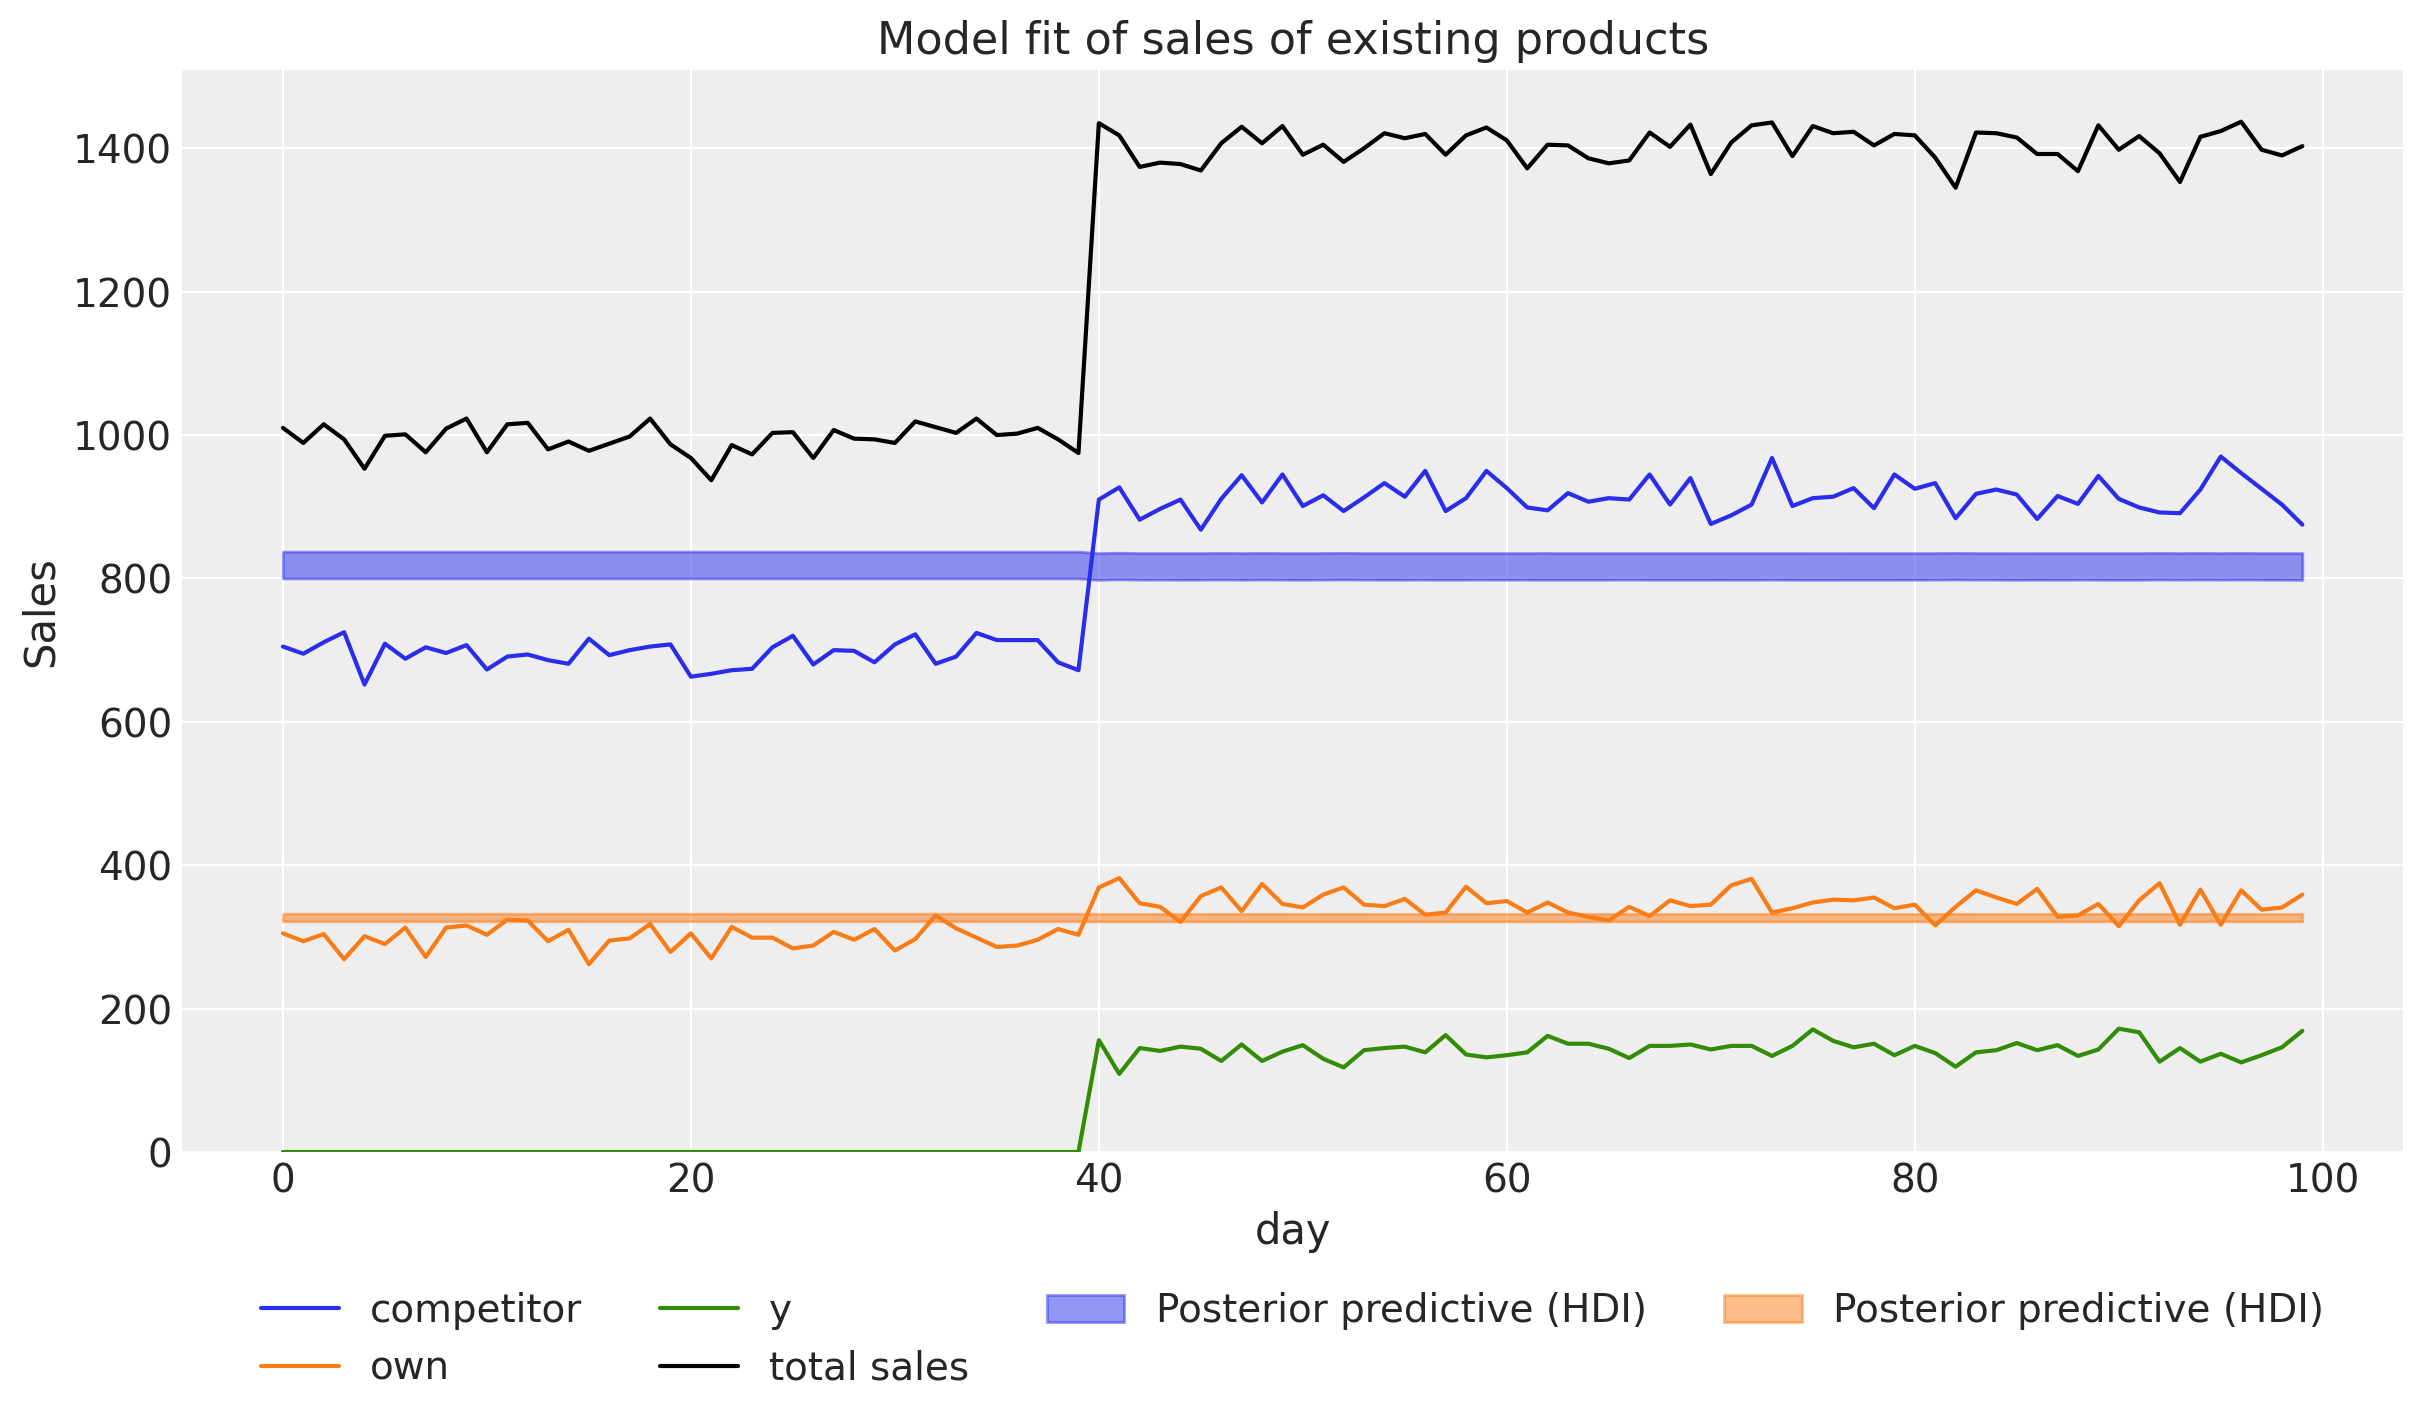

In [17]:
fig, ax = plt.subplots()
model2.plot_fit(ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4);

Equally, the counterfactual predictions are poor in that they do not represent what we'd expect to see. Namely, we'd expect the relatively constant sales numbers to continue on as they were after the new product was introduced.

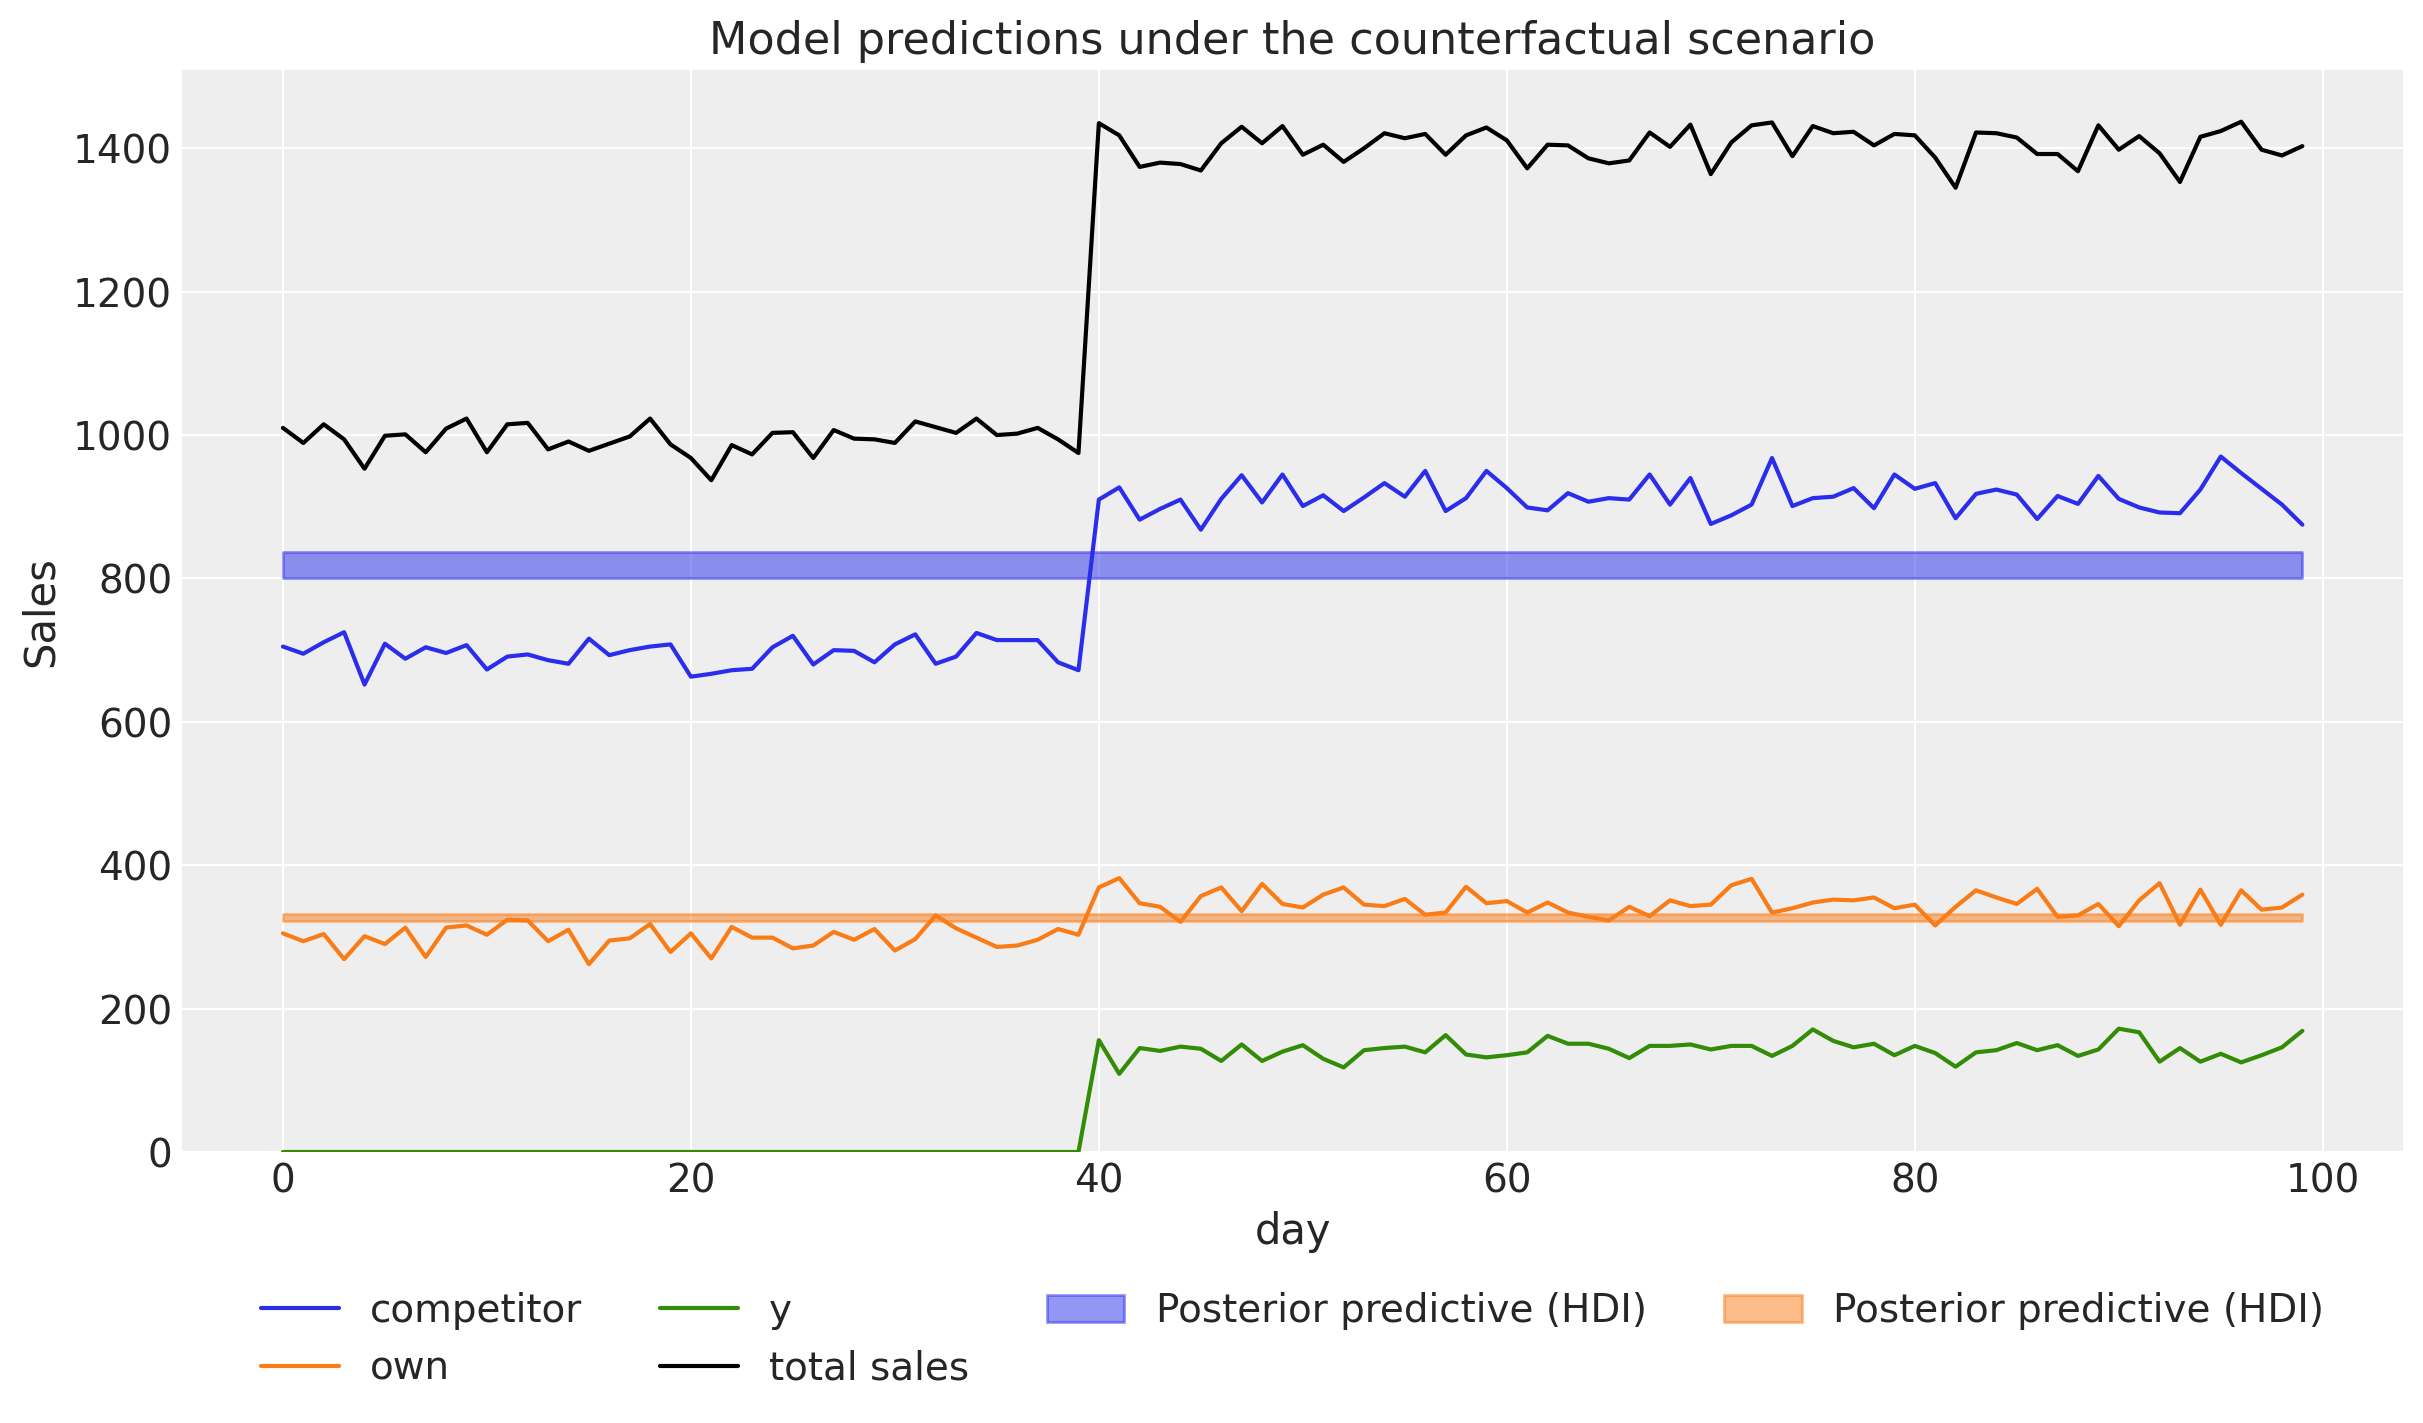

In [18]:
fig, ax = plt.subplots()
model2.plot_counterfactual(ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4);

If we examine the parameters (in the unsaturated market case we examine `beta_all`, not `beta`) we can see that the model attributes a near zero reduction in the existing competitor and own company products. There is no reduction of course, the sales numbers actually _increased_ despite the market share decreasing.

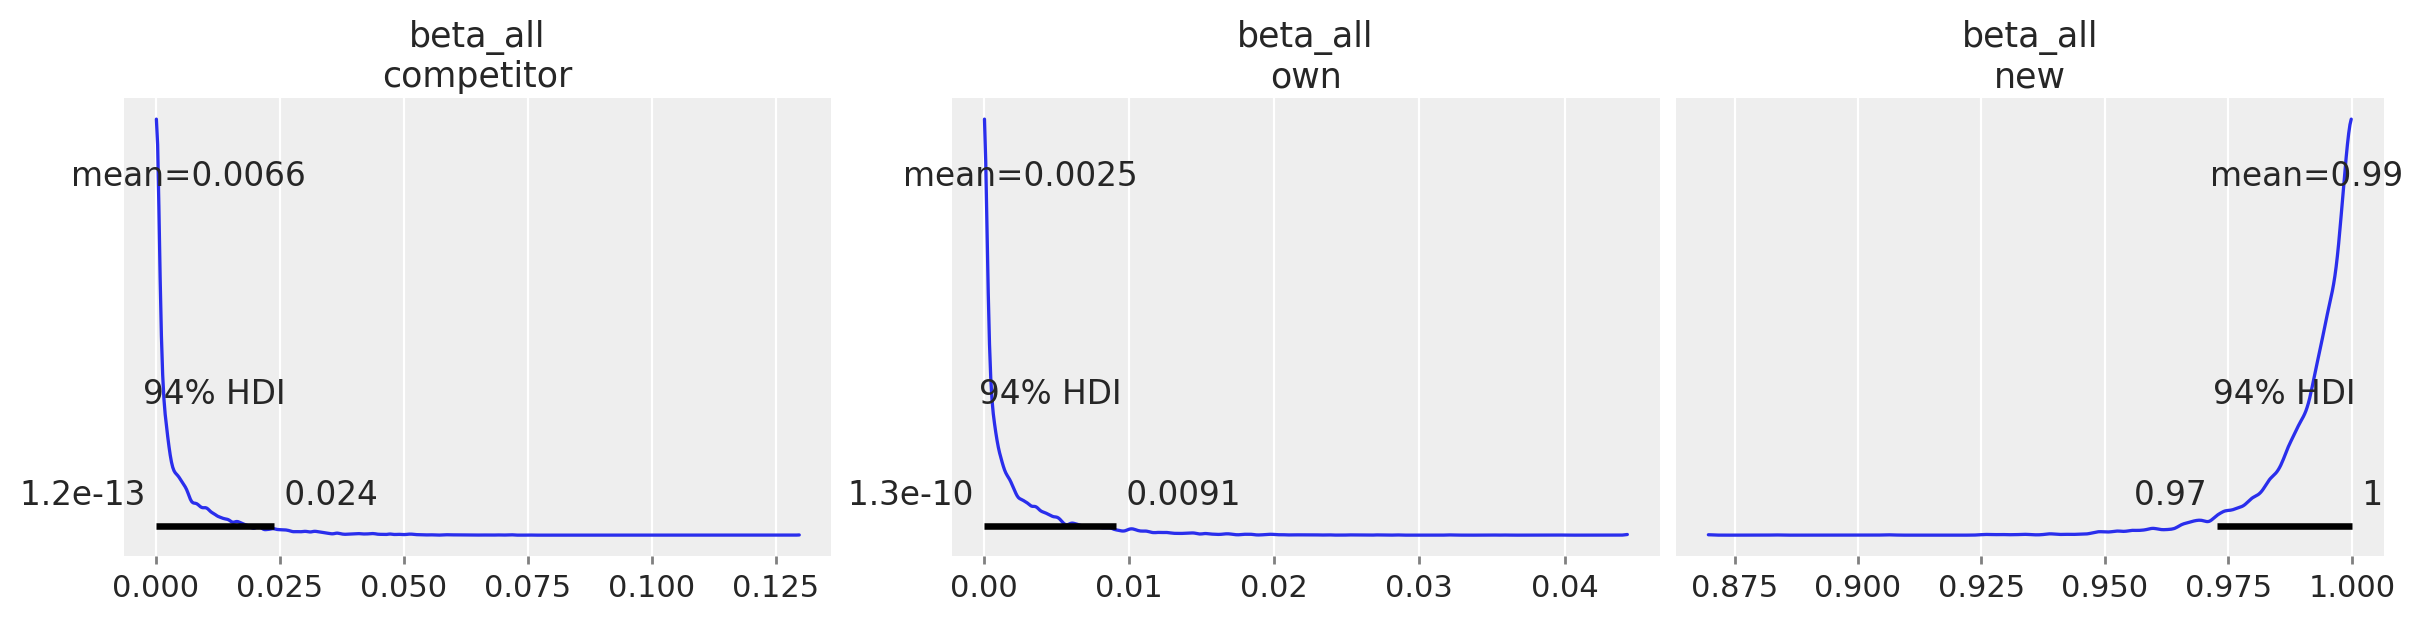

In [19]:
az.plot_posterior(model2.idata, var_names=["beta_all"], textsize=11, figsize=(12, 3));

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Sat Dec 28 2024

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

pymc_marketing: 0.10.0
pytensor      : 2.22.1

matplotlib    : 3.10.0
numpy         : 1.26.4
pymc_marketing: 0.10.0
arviz         : 0.20.0

Watermark: 2.5.0

